<a href="https://colab.research.google.com/github/babybunso/dl_playground/blob/main/notebooks/tfdl_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn import datasets as D
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

s_scaler = StandardScaler()
m_scaler = MinMaxScaler()

from collections import Counter

import torch
import torch.nn as nn
import torchaudio
import torchvision

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib_inline

plt.style.use('dark_background')

from IPython import display
display.set_matplotlib_formats('svg')
import time
import os

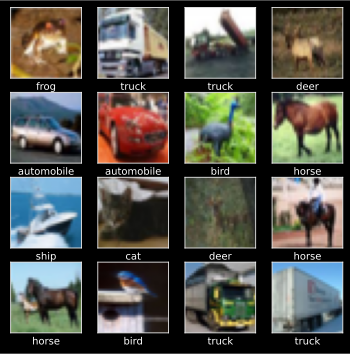

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 1152)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [14]:
%%time

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.datasets import cifar10

# cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

class_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

def imshow():
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_train[i], cmap=plt.cm.binary)
        # The CIFAR label happens to be arrays, which why I need extra index
        plt.xlabel(class_labels[y_train[i][0]])
    plt.show()

imshow()

#################################################################################################################
# model
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
print(model.summary())

# loss, optimizer and metrics
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# metrics = ['accuracy']
metrics = [keras.metrics.SparseCategoricalAccuracy()]

# compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# training
batch_size = 64
epochs = 100
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# evaluate

result = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=2)

print(f' Result: {result}')


In [15]:
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.7.0


In [23]:
# scalars
string = tf.Variable('This is a string', tf.string)
number = tf.Variable(324, tf.int16)
floating = tf.Variable(3.456789797899, tf.float64)

In [25]:
# arrays
rank_1 = tf.Variable(['blah...', 'dsfsdfdsf', 'sdfdsfsdf'], tf.string)
rank_2 = tf.Variable([['blah...', 'dsfsdfdsf', 'sdfdsfsdf'], ['blah...', 'dsfsdfdsf', 'sdfdsfsdf'], ['blah...', 'dsfsdfdsf', 'sdfdsfsdf']], tf.string)
print(rank_1)
print()
print(rank_2)

<tf.Variable 'Variable:0' shape=(3,) dtype=string, numpy=array([b'blah...', b'dsfsdfdsf', b'sdfdsfsdf'], dtype=object)>

<tf.Variable 'Variable:0' shape=(3, 3) dtype=string, numpy=
array([[b'blah...', b'dsfsdfdsf', b'sdfdsfsdf'],
       [b'blah...', b'dsfsdfdsf', b'sdfdsfsdf'],
       [b'blah...', b'dsfsdfdsf', b'sdfdsfsdf']], dtype=object)>


In [27]:
rank_2.shape

TensorShape([3, 3])

In [8]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.7.0
/device:GPU:0
Num GPUs Available:  1


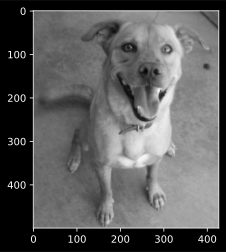

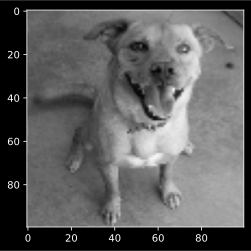

X shape: (24946, 100, 100)
y shape: (24946,)


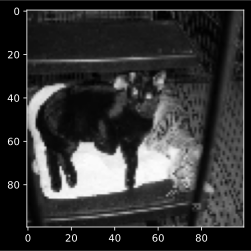

Cat: 1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 activation_4 (Activation)   (None, 98, 98, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 activation_5 (Activation)   (None, 47, 47, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                           

In [9]:
# Ex02a cats and dogs
# dataset: https://www.microsoft.com/en-us/download/details.aspx?id=54765

import cv2
import os
import random
import time
import joblib

BASE_DIR = 'drive/MyDrive/sample_data'
DATA_DIR = f'{BASE_DIR}/PetImages/'
CATEGORIES = ['Dog', 'Cat']
IMG_SIZE = 100

def check_data():
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, category)
        for img in os.listdir(path):
            # orig image
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            plt.imshow(img_arr, cmap='gray')
            plt.show()
            # resize image
            new_img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            plt.imshow(new_img_arr, cmap='gray')
            plt.show()
            break
        break

def create_training_data():
    data = []
    for c in CATEGORIES:
        path = os.path.join(DATA_DIR, c)
        class_label = CATEGORIES.index(c)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([img_arr, class_label])
            except Exception as e:  pass

    random.shuffle(data)

    features = [feature for feature,_ in data]
    labels = [label for _, label in data]
    return np.array(features), np.array(labels)

def check_one(idx):
    plt.imshow(X[idx], cmap='gray')
    plt.show()
    print(f'{CATEGORIES[y[idx]]}: {y[idx]}')

def save_data(X, y, X_filename, y_filename):
    joblib.dump(X, X_filename)
    joblib.dump(y, y_filename)

check_data()

X, y = create_training_data()
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
check_one(100)

X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.

save_data(X, y, f'{BASE_DIR}/X_dogs_cats.data', f'{BASE_DIR}/y_dogs_cats.data')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import TensorBoard

MODEL_NAME = f'dog_cat_model{int(time.time())}.model'
tensorboard = TensorBoard(log_dir=f'{BASE_DIR}/logs/{MODEL_NAME}')


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

optim = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])

model.summary()

model.fit(X, y, epochs=100,  batch_size=32, validation_split=.2, verbose=2, callbacks=[tensorboard])
